# Burger's Equation — Two Colliding Bumps

Burger's equation governs the battle between **nonlinear convection** (waves self-advecting) and **diffusion** (viscous smoothing):

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

**Where:**
- $u(t, x)$ = velocity at position $x$ and time $t$
- $u\frac{\partial u}{\partial x}$ = nonlinear convection term — positive velocity moves right, negative moves left
- $\nu \frac{\partial^2 u}{\partial x^2}$ = diffusion term — smears out sharp features
- $\nu = \frac{0.01}{\pi}$ = viscosity (small → diffusion is weak → shocks can form)

**Physical meaning:** A positive bump pushes itself rightward. A negative bump pushes itself leftward. Start them facing each other and they collide head-on — steepening, compressing, and eventually annihilating into diffused noise. It's a controlled car crash in velocity space.

---

## This Problem Setup

**Domain:** $x \in [0, 2]$, $t \in [0, 2]$

**Initial Condition — Two Colliding Gaussians:**

$$u(x, 0) = 1.2\, e^{-100(x - 0.7)^2} - 1.2\, e^{-100(x - 1.3)^2}$$

Two sharp, symmetric bumps of equal magnitude sit $0.6$ apart. The positive bump at $x = 0.7$ travels rightward. The negative bump at $x = 1.3$ travels leftward. They are on a collision course from the start.

**Boundary Conditions (Dirichlet):**

$$u(0, t) = 0 \quad \text{and} \quad u(2, t) = 0$$

Velocity is pinned to zero at both walls — the bumps play out entirely within the domain before being absorbed at the edges.

In [7]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

import jax.numpy as jnp

import copy

# Problem parameters

v = 0.01/jnp.pi  # viscosity
L = 2  # length of domain
T = 2.0  # final time


# Initial condition: TWO COLLIDING GAUSSIANS
x_ic = jnp.linspace(0, L, 50).reshape(-1, 1)
t_ic = jnp.zeros((50, 1))

# One positive (travels right), one negative (travels left)
u_ic = (1.2 * jnp.exp(-100*(x_ic - 0.7)**2) - 
        1.2 * jnp.exp(-100*(x_ic - 1.3)**2))


# 2. Boundary Condition points (20 total: 10 at each edge)
# Using Dirichlet boundaries: u(0, t) = 0, u(L, t) = 0 - fixed values at edges

# 2. Boundary Condition points (20 total: 10 at each edge)
# Left boundary (x=0):
t_bc_left = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_right = L * jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1)) # u=0 at both boundaries for all times


# 3. Physics collocation points (30×30 = 900 points)
t_vals = jnp.linspace(0, T, 50)
x_vals = jnp.linspace(0, L, 50)
T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
t_physics = T_grid.reshape(-1, 1)
x_physics = X_grid.reshape(-1, 1)



# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., 
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point, v):

    def u(t_val, x_val):
        tx_in = jnp.array([[t_val, x_val]])
        return network(params, tx_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point)

    du_dx = grad(u, argnums = 1)(t_point, x_point)

    u_ = u(t_point, x_point)

    d2u_dx2 = grad(grad(u, argnums = 1), argnums=1)(t_point, x_point)

    return du_dt + u_ * du_dx - v * d2u_dx2
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x) pair, keeping params fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0, None))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [2, 64, 64, 64, 64, 1]  # Deeper than current [2, 32, 32, 32, 1]
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, u_ic, 
                t_bc, x_bc, u_bc, t_physics, x_physics, v):

    def loss_fn(params):
        # 1. Initial Condition Loss
        # Network prediction at IC points
        tx_ic = jnp.concatenate([t_ic, x_ic], axis=1)  # Combine t and x
        u_pred_ic = network(params, tx_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss

        """
        # Periodic  boundaries
        tx_bc_left = jnp.concatenate([t_bc_left, x_bc_left], axis=1)
        u_pred_bc_left = network(params, tx_bc_left)

        tx_bc_right = jnp.concatenate([t_bc_right, x_bc_right], axis=1)
        u_pred_bc_right = network(params, tx_bc_right)

        bc_loss = jnp.mean((u_pred_bc_left - u_pred_bc_right)**2)

        """

        tx_bc = jnp.concatenate([t_bc, x_bc], axis=1)
        u_pred_bc = network(params, tx_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)

        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), # (900,) not (900, 1)
                                                x_physics.ravel(), # (900,) not (900, 1)
                                                v
                                                )
        physics_loss = (1e-2) * jnp.mean(physics_residuals**2) # Physics residual is of 900 points. Much more than our ic and bc points. Therefore we multiply by 1e-4 so it doesn't overpower
        
        return ic_loss + bc_loss + physics_loss
    
        # Compute loss and gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val


# Training parameters
num_iterations = 20000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()

# Training loop
losses = []
for i in range(num_iterations):
    params, opt_state, loss = update_step(
        params, opt_state,
        t_ic, x_ic, u_ic,
        t_bc, x_bc, u_bc,
        t_phys_flat, x_phys_flat,
        v
        )
    
    losses.append(loss)


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")





Iteration 1000/20000, Loss: 0.002821
Iteration 2000/20000, Loss: 0.001312
Iteration 3000/20000, Loss: 0.000940
Iteration 4000/20000, Loss: 0.000721
Iteration 5000/20000, Loss: 0.000503
Iteration 6000/20000, Loss: 0.000452
Iteration 7000/20000, Loss: 0.000287
Iteration 8000/20000, Loss: 0.000276
Iteration 9000/20000, Loss: 0.000138
Iteration 10000/20000, Loss: 0.000128
Iteration 11000/20000, Loss: 0.000082
Iteration 12000/20000, Loss: 0.000048
Iteration 13000/20000, Loss: 0.000037
Iteration 14000/20000, Loss: 0.000041
Iteration 15000/20000, Loss: 0.000059
Iteration 16000/20000, Loss: 0.000043
Iteration 17000/20000, Loss: 0.000036
Iteration 18000/20000, Loss: 0.000058
Iteration 19000/20000, Loss: 0.000018
Iteration 20000/20000, Loss: 0.000068


## plot time slices

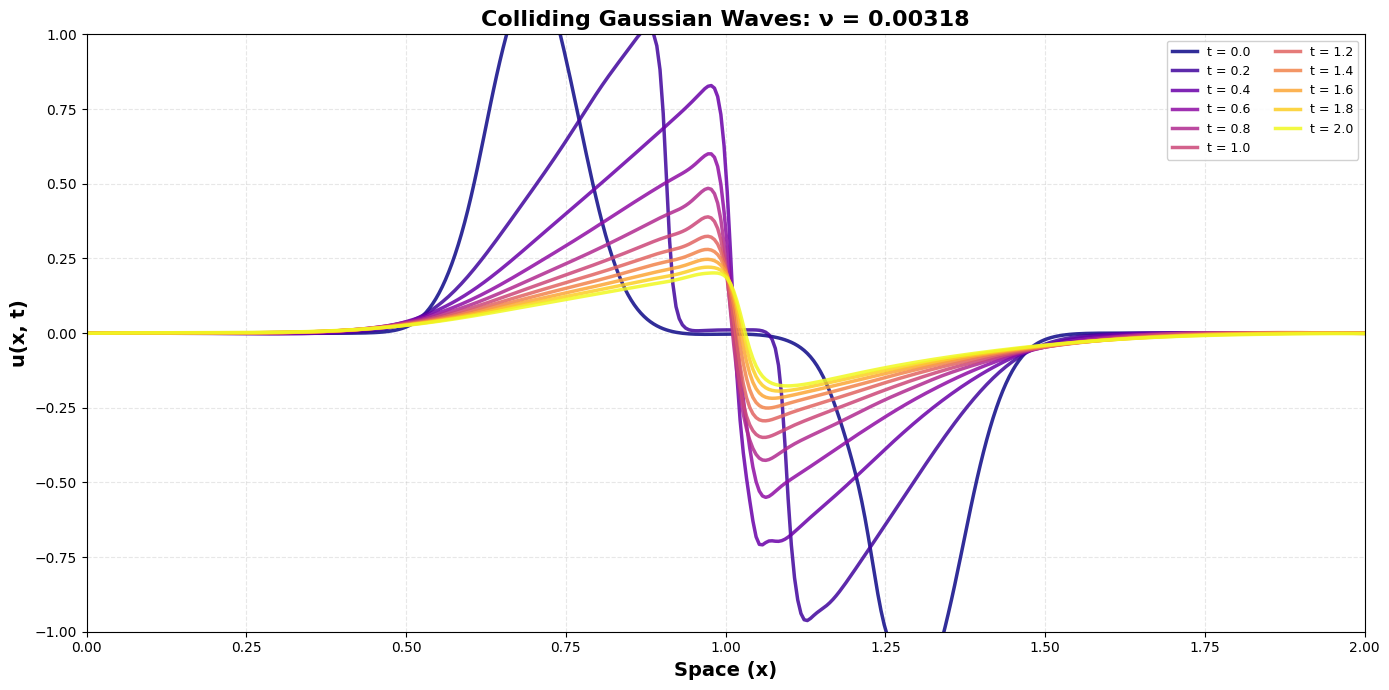

In [8]:
def plot_collision_time_slices():
    """Plot collision evolution"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # Focus on collision times
    time_slices = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
    x_vals = jnp.linspace(0, 2.0, 400)
    
    colors = plt.cm.plasma(jnp.linspace(0, 1, len(time_slices)))
    
    for idx, t_val in enumerate(time_slices):
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params, tx_input).ravel()
        
        label = f't = {t_val:.1f}'
        ax.plot(x_vals, u_pred, color=colors[idx], linewidth=2.5, 
                label=label, alpha=0.85)
    
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title(f'Colliding Gaussian Waves: ν = {v:.5f}', 
                 fontsize=16, fontweight='bold')
    ax.set_xlim(0, 2.0)
    ax.set_ylim(-1.0, 1.0)  # Taller for collision peak!
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9, ncol=2)
    
    plt.tight_layout()
    plt.savefig('collision_time_slices.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_collision_time_slices()

In [11]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_collision_animation():
    """Create animated GIF of collision"""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x_vals = jnp.linspace(0, 2, 400)
    
    # Time points for animation
    time_points = jnp.linspace(0, 2, 100)  # 100 frames
    
    # Initialize line
    line, = ax.plot([], [], 'b-', linewidth=3, label='PINN Solution')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                       fontsize=14, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Add collision zone marker
    ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.3, label='Collision zone')
    
    # Set fixed axes
    ax.set_xlim(0, 2)
    ax.set_ylim(-1.1, 1.1)  # Include negative values
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title(f'Colliding Waves: ν = {v:.5f}', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=12)
    
    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    
    def animate(frame):
        t_val = time_points[frame]
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params, tx_input).ravel()
        
        line.set_data(x_vals, u_pred)
        time_text.set_text(f't = {t_val:.3f}')
        return line, time_text
    
    # Create animation
    print("Creating collision animation... (30-60 seconds)")
    anim = FuncAnimation(fig, animate, init_func=init,
                        frames=len(time_points), interval=50, 
                        blit=True, repeat=True)
    
    # Save as GIF
    writer = PillowWriter(fps=20)
    anim.save('collision_animation.gif', writer=writer, dpi=150)
    print("✓ Collision animation saved as 'collision_animation.gif'")
    
    plt.close()

create_collision_animation()

Creating collision animation... (30-60 seconds)
✓ Collision animation saved as 'collision_animation.gif'
